In [26]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from u_net_modules import *

from u_net_modules import UNET_v3
import time
from torchsummary import summary
import torchviz
import matplotlib.pyplot as plt

In [27]:
train=False

In [28]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input_folder, target_folder):
        self.folder_path = input_folder
        self.target_path = target_folder

        self.input_file_list = os.listdir(input_folder)
        self.target_file_list = os.listdir(target_folder)

    def __len__(self):
        return len(self.input_file_list)

    def __getitem__(self, idx):
        input_file_name = self.input_file_list[idx]
        input_file_id = input_file_name.split('_')[-1].split('.')[0]

        # Sprawdzamy, czy istnieje odpowiadający plik docelowy
        target_file_name = f'TARGET_{input_file_id}.npy'
        target_file_path = os.path.join(self.target_path, target_file_name)

        if os.path.exists(target_file_path):
            input_file_path = os.path.join(self.folder_path, input_file_name)
            try:
                input_data = np.load(input_file_path)
                target_data = np.load(target_file_path)

                input_tensor = torch.tensor(input_data[1, :, :, :], dtype=torch.float32)
                target_tensor = torch.tensor(target_data[0, :, :], dtype=torch.float32)

                return input_tensor, target_tensor
            except TypeError as e:
                # Jeśli wystąpił błąd TypeError, wypisz nazwę pliku, który spowodował błąd
                print(f"Błąd w przetwarzaniu pliku: {input_file_name}, Error: {str(e)}")
                return None, None
        else:
            # Jeśli plik docelowy nie istnieje, zwracamy None w celu pominięcia tego przykładu
            return None, None

def collate_fn(batch):
    # Usuwamy None z listy batch
    batch = [x for x in batch if x[0] is not None]

    if len(batch) == 0:
        # Jeśli wszystkie pliki były puste (brak odpowiadających plików docelowych), zwracamy pustą listę
        return [], []

    # Sortujemy batch względem długości sekwencji w tensorze input
    batch = sorted(batch, key=lambda x: x[0].size(2), reverse=True)

    # Rozszerzenie danych docelowych o wymiar channels
    target_data = torch.stack([x[1] for x in batch])

    # Zamiana kolejności kanałów i klatek czasowych w danych wejściowych
    input_data = torch.stack([x[0] for x in batch])

    return input_data, target_data


In [29]:
def accuracy(pred,target):

    correct=(pred==target).sum().item()

    total=target.numel()
    accuracy=correct/total

    return accuracy



def test_model(model,data_loader,criterion, device):
    
    model.eval()

    total_accuracy=0.0
    num_samples=0

    with torch.no_grad():
        for batch,target in data_loader:
            
            batch = batch.to(device)
            target = target.to(device)

            output = model(batch)
            loss = criterion(output,target)

            batch_accuracy = accuracy(output,target)

            batch_size=batch.size(0)
            total_accuracy+=batch_accuracy*batch_size
            num_samples+=batch_size
            print("testing")
    
    test_accuracy=total_accuracy/num_samples

    print(f"Test Accuracy: {test_accuracy:.4f}")



In [30]:
# Sprawdzenie dostępności GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available:
    device="cuda"
    print("GPU available")
else:
    device="cpu"
    print("GPU unavailable only CPU")


# Tworzymy instancję klasy Dataset
print("Data loading...")
input_folder = r'F:\mgr_datasets\PASTIS_SMOLL\DATA_S2'
target_folder=r'F:\mgr_datasets\PASTIS_SMOLL\ANNOTATIONS'
custom_dataset = CustomDataset(input_folder,target_folder)

# Podział na dane testowe i treningowe
dataset_size = len(custom_dataset)
train_size = int(0.8 * dataset_size)  # 80% danych treningowych
test_size = dataset_size - train_size

# Dokonujemy losowego podziału na dane treningowe i testowe
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Tworzymy DataLoader z użyciem collate_fn
batch_size = 128
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_test=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)

for input_batch, target_batch in data_loader_train:
    # print("Kształt danych wejściowych:", input_batch.shape)
    # print("Kształt danych docelowych:", target_batch.shape)
    break  # Wyświetlamy tylko pierwszy batch

print("Loading successful")


print("Model initialization...")
# Tworzenie modelu sieci U-TAE
in_channels = 10  # Liczba kanałów wejściowych
out_channels = 20  # Liczba kanałów wyjściowych dla problemu klasyfikacji
sequence_length = 61  # Długość szeregu czasowego (ilość zdjęć w sekwencji)
height, width = 128, 128  # Rozmiary wymiarów przestrzennych
# model = UNET_v1(in_channels, out_channels,sequence_length)
model=UNET_v3(in_channels,out_channels)
model.to(device)  # Przenosimy model do GPU
print("Model ready")


GPU available
Data loading...
Loading successful
Model initialization...
Model ready


In [31]:


criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)



if train:
    num_epochs=200


    loss_vector=[]

    print("Training...")
    for epoch in range(num_epochs):
        # i=0
        start_time=time.time()
        # Teraz możemy iterować przez DataLoader i pobierać dane wsadowo podczas trenowania sieci
        for batch,target in data_loader_train:
            # if i%10==0:
            #     print("batches: ", i)
            # i=i+1
            batch = batch.to(device)
            optimizer.zero_grad()
            output,predictions=model(batch)
            
            target=target.to(device)
            # print('target size:',target.shape)

            # print('pred type', predictions.dtype)
            # print('target type', target.dtype)

            # output.requires_grad = True  # Dodaj to, aby umożliwić obliczanie gradientów dla predictions
            loss=criterion(output,target.long())

            loss.backward()
            optimizer.step()
        end_time=time.time()
        
        elapsed_time=end_time-start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        print(F'Time per epoch: {elapsed_time:.2f} s')
        loss_vector.append(loss.item())

else:
    model.load_state_dict(torch.load(r'F:\pytong\unet_to_notimeseries_source\model.pth'))
    model.to(device)  # Przenosimy model do GPU
    model.eval()


In [32]:
if train:
    plt.plot(range(len(loss_vector)),loss_vector)
    plt.xlabel('epoch')
    plt.ylabel('loss')

In [33]:
if train:
    sample=30

    image_batch = predictions[sample, :, :].cpu().detach().numpy()

    source = batch[sample,3, :, :].cpu()

    image_target = target[sample, :, :].cpu()
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Tworzy jeden wiersz i dwa wykresy obok siebie

    # Pierwszy wykres dla image_batch
    axes[0].imshow(image_batch)
    axes[0].set_title('Predictions')

    # Drugi wykres dla image_target
    axes[1].imshow(image_target)
    axes[1].set_title('Target')

    axes[2].imshow(source)
    axes[2].set_title('Source')

    plt.show()

In [34]:
# test_model(model,data_loader_test,criterion,device)

model.eval()

total_accuracy=0.0
num_samples=0

with torch.no_grad():
    for batch,target in data_loader_test:
            
        batch = batch.to(device)
        target = target.to(device)

        output,pred = model(batch)
        loss = criterion(pred,target)

        batch_accuracy = accuracy(pred,target)

        batch_size=batch.size(0)
        total_accuracy+=batch_accuracy*batch_size
        num_samples+=batch_size
        print("testing")

  
test_accuracy=total_accuracy/num_samples

print(f"Test Accuracy: {test_accuracy:.4f}")


testing
Test Accuracy: 0.4737


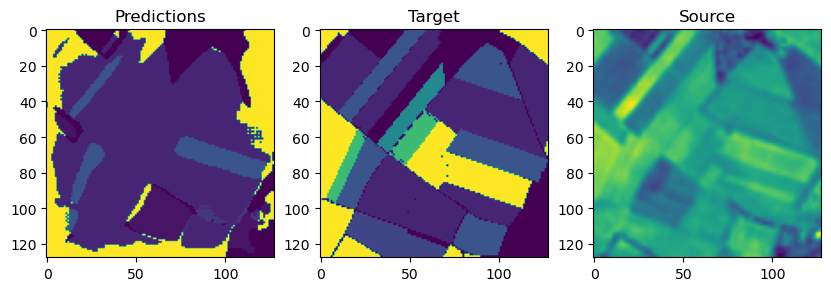

In [40]:
sample=5

image_batch = pred[sample, :, :].cpu().detach().numpy()

source = batch[sample,3, :, :].cpu()

image_target = target[sample, :, :].cpu()
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Tworzy jeden wiersz i dwa wykresy obok siebie

# Pierwszy wykres dla image_batch
axes[0].imshow(image_batch)
axes[0].set_title('Predictions')

# Drugi wykres dla image_target
axes[1].imshow(image_target)
axes[1].set_title('Target')

axes[2].imshow(source)
axes[2].set_title('Source')

plt.show()

In [36]:
if train:
    torch.save(model.state_dict(),'model.pth')

# Zaimportuj bibliotekę matplotlib
import matplotlib.pyplot as plt

# Przekopiuj tensor na urządzenie CPU i przekształć na numpy array
read_data = output[2, 0, :, :].cpu().numpy()

# Przeskaluj wartości do zakresu od 0 do 255
# scaled_image = (read_data ).astype(np.uint8)

# Utwórz unikalną listę etykiet
unique_labels = np.unique(read_data)

# Wybierz mapę kolorów z matplotlib (np. 'viridis', 'jet', 'coolwarm', 'rainbow', itp.)
cmap_name = 'viridis'

# Wygeneruj mapę kolorów na podstawie etykiet i wybranej mapy kolorów
cmap = plt.get_cmap(cmap_name, len(unique_labels))

# Wygeneruj obraz kolorowy na podstawie etykiet i mapy kolorów
colored_image = cmap(read_data)
plt.imshow(colored_image)
plt.show()


max_val=np.max(read_data)
min_val=np.min(read_data)

scaled_read=read_data

unique_1=np.unique(scaled_read)
print(len(unique_1))

print(np.max(scaled_read))
print(np.min(scaled_read))

plt.imshow(scaled_read)
plt.show()

img_from_batch=batch[2,0:3,1,:,:]
permute_img=img_from_batch.permute(1,2,0)





permute_img=permute_img

scaled_permute=(permute_img/7000)
plt.imshow(scaled_permute.cpu().numpy())
plt.show()





model.eval()
model_path=r'F:\pytong\utaeV2\MODEL\U_NET_V1.pth'
torch.save(model.state_dict(),model_path)